In [1]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs

# !pip install pybbn

# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [2]:
# Set Pandas options to display more columns
pd.options.display.max_columns=50

# Read in the weather data csv
df=pd.read_csv('weatherAUS.csv', encoding='utf-8')

# Drop records where target RainTomorrow=NaN
df=df[pd.isnull(df['RainTomorrow'])==False]

# For other columns with missing values, fill them in with column mean
df=df.fillna(df.mean())

# Create bands for variables that we want to use in the model
df['WindGustSpeedCat']=df['WindGustSpeed'].apply(lambda x: '0.<=40'   if x<=40 else
                                                            '1.40-50' if 40<x<=50 else '2.>50')
df['Humidity9amCat']=df['Humidity9am'].apply(lambda x: '1.>60' if x>60 else '0.<=60')
df['Humidity3pmCat']=df['Humidity3pm'].apply(lambda x: '1.>60' if x>60 else '0.<=60')

# Show a snaphsot of data
df

C:\Users\dlaa0001\AppData\Local\Temp/ipykernel_9576/3896963401.py:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df=df.fillna(df.mean())


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,WindGustSpeedCat,Humidity9amCat,Humidity3pmCat
0,2008-12-01,Albury,13.4,22.9,0.6,5.469824,7.624853,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.000000,4.503167,16.9,21.8,No,No,1.40-50,1.>60,0.<=60
1,2008-12-02,Albury,7.4,25.1,0.0,5.469824,7.624853,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,4.437189,4.503167,17.2,24.3,No,No,1.40-50,0.<=60,0.<=60
2,2008-12-03,Albury,12.9,25.7,0.0,5.469824,7.624853,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,4.437189,2.000000,21.0,23.2,No,No,1.40-50,0.<=60,0.<=60
3,2008-12-04,Albury,9.2,28.0,0.0,5.469824,7.624853,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,4.437189,4.503167,18.1,26.5,No,No,0.<=40,0.<=60,0.<=60
4,2008-12-05,Albury,17.5,32.3,1.0,5.469824,7.624853,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.000000,8.000000,17.8,29.7,No,No,1.40-50,1.>60,0.<=60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,2017-06-20,Uluru,3.5,21.8,0.0,5.469824,7.624853,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,4.437189,4.503167,9.4,20.9,No,No,0.<=40,0.<=60,0.<=60
145455,2017-06-21,Uluru,2.8,23.4,0.0,5.469824,7.624853,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,4.437189,4.503167,10.1,22.4,No,No,0.<=40,0.<=60,0.<=60
145456,2017-06-22,Uluru,3.6,25.3,0.0,5.469824,7.624853,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,4.437189,4.503167,10.9,24.5,No,No,0.<=40,0.<=60,0.<=60
145457,2017-06-23,Uluru,5.4,26.9,0.0,5.469824,7.624853,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,4.437189,4.503167,12.5,26.1,No,No,0.<=40,0.<=60,0.<=60


In [3]:
# Create nodes by manually typing in probabilities
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), [0.30658, 0.69342])
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), [0.92827, 0.07173, 
                                                      0.55760, 0.44240])
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), [0.58660, 0.24040, 0.17300])
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), [0.92314, 0.07686, 
                                                0.89072, 0.10928, 
                                                0.76008, 0.23992, 
                                                0.64250, 0.35750, 
                                                0.49168, 0.50832, 
                                                0.32182, 0.67818])

In [4]:
# This function helps to calculate probability distribution, which goes into BBN (note, can handle up to 2 parents)
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [5]:
# Create nodes by using our earlier function to automatically calculate probabilities
H9am = BbnNode(Variable(0, 'H9am', ['<=60', '>60']), probs(df, child='Humidity9amCat'))
H3pm = BbnNode(Variable(1, 'H3pm', ['<=60', '>60']), probs(df, child='Humidity3pmCat', parent1='Humidity9amCat'))
W = BbnNode(Variable(2, 'W', ['<=40', '40-50', '>50']), probs(df, child='WindGustSpeedCat'))
RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', parent1='Humidity3pmCat', parent2='WindGustSpeedCat'))

# Create Network
bbn = Bbn() \
    .add_node(H9am) \
    .add_node(H3pm) \
    .add_node(W) \
    .add_node(RT) \
    .add_edge(Edge(H9am, H3pm, EdgeType.DIRECTED)) \
    .add_edge(Edge(H3pm, RT, EdgeType.DIRECTED)) \
    .add_edge(Edge(W, RT, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)


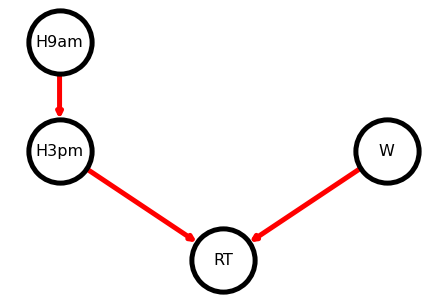

In [6]:
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

In [7]:
# Define a function for printing marginal probabilities
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node:", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.67124
1=>60|0.32876
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.30658
0=>60|0.69342
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.77655
3=Yes|0.22345
----------------


In [8]:
# To add evidence of events that happened so probability distribution can be recalculated
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder() \
    .with_node(join_tree.get_bbn_node_by_name(nod)) \
    .with_evidence(cat, val) \
    .build()
    join_tree.set_observation(ev)
    
# Use above function to add evidence
evidence('ev1', 'H9am', '>60', 1.0)

# Print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.55760
1=>60|0.44240
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.00000
0=>60|1.00000
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.58660
2=40-50|0.24040
2=>50|0.17300
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.73833
3=Yes|0.26167
----------------


In [9]:
# Add more evidence
evidence('ev1', 'H3pm', '>60', 1.0)
evidence('ev2', 'W', '>50', 1.0)
# Print marginal probabilities
print_probs()

Node: 1|H3pm|<=60,>60
Values:
1=<=60|0.00000
1=>60|1.00000
----------------
Node: 0|H9am|<=60,>60
Values:
0=<=60|0.00000
0=>60|1.00000
----------------
Node: 2|W|<=40,40-50,>50
Values:
2=<=40|0.00000
2=40-50|0.00000
2=>50|1.00000
----------------
Node: 3|RT|No,Yes
Values:
3=No|0.32182
3=Yes|0.67818
----------------


In [10]:
# Code for covering up to 5 parents
# Credit to Andy Hughes for this piece of code (https://medium.com/@andyhughes1977) 
def probs(df, child, childbands, 
          parent1=None, parent1bands=None, 
          parent2=None, parent2bands=None, 
          parent3=None, parent3bands=None, 
          parent4=None, parent4bands=None, 
          parent5=None):
    # Initialize empty list
    prob=[]
    if parent1==None:
        # Calculate probabilities
        for val in childbands:
            prob.append(df[child].tolist().count(val))
            prob = [i/sum(prob) for i in prob]
    elif parent1!=None:
        # Check if parent2 exists
        if parent2==None:
            # Calcucate probabilities
            for val in parent1bands:
                for val2 in childbands:
                    prob.append(df[df[parent1]==val][child].tolist().count(val2))
                    prob = [i/sum(prob) for i in prob]
        elif parent2!=None:
            # Check if parent3 exists
            if parent3==None:
                # Calcucate probabilities
                for val in parent1bands:
                    for val2 in parent2bands:
                        for val3 in childbands:
                            prob.append(df[(df[parent1]==val) & (df[parent2]==val2)][child].tolist().count(val3))
                            prob = [i/sum(prob) for i in prob]
            elif parent3!=None:
                # Check if parent4 exists
                if parent4==None:
                    # Calcucate probabilities
                    for val in parent1bands:
                        for val2 in parent2bands:
                            for val3 in parent3bands:
                                for val4 in childbands:
                                    prob.append(df[(df[parent1]==val) & (df[parent2]==val2) & (df[parent3]==val3)][child].tolist().count(val4))
                                    prob = [i/sum(prob) for i in prob]
                elif parent4!=None:
                    # Check if parent5 exists
                    if parent5==None:
                        # Calcucate probabilities
                            for val in parent1bands:
                                for val2 in parent2bands:
                                    for val3 in parent3bands:
                                        for val4 in parent4bands:
                                            for val5 in childbands:
                                                prob.append(df[(df[parent1]==val) & (df[parent2]==val2) & (df[parent3]==val3) & (df[parent4]==val4)][child].tolist().count(val5))
                                                prob = [i/sum(prob) for i in prob]
    return prob

#Example for calling this function:
#RT = BbnNode(Variable(3, 'RT', ['No', 'Yes']), probs(df, child='RainTomorrow', childbands=['No', 'Yes'], 
#                                                     parent1='Humidity3pmCat', parent1bands=['0.<=60', '1.>60'], 
#                                                     parent2='WindGustSpeedCat', parent2bands=['0.<=40', '1.40-50', '2.>50']))